# SVM Classification Using Individual Replicas
This notebook analyzes the quality of the classifiers resulting from training on individual replicas of read counts rather than averaged values. Data are adjusted for library size and gene length.

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest
from common_python.plots import util_plots as common_plots

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

## Analyze Replica Data
The following shows the extent to which replicas agree with the tranary values that are assigned.

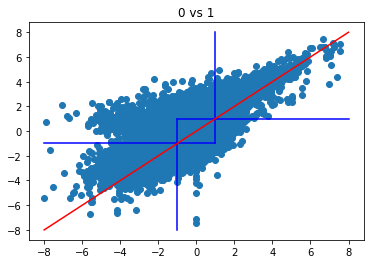

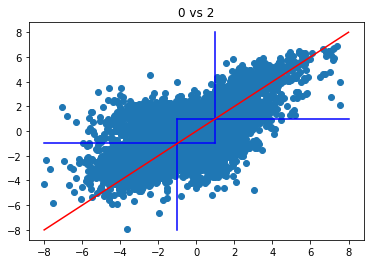

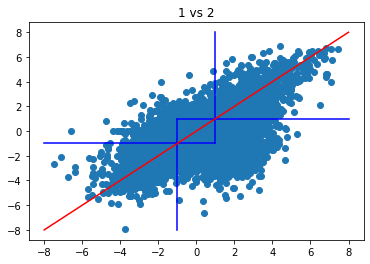

In [2]:
def compareDFValues(df1, df2, title):
    RANGE = [-8, 8]
    plt.figure()
    arr1 = df1.values.flatten()
    arr2 = df2.values.flatten()
    plt.scatter(arr1, arr2)
    # Define region of 0 values
    plt.plot([-1, -1], [-1, 1], color="b")
    plt.plot([1, 1], [-1, 1], color="b")
    plt.plot([-1, 1], [-1, -1], color="b")
    plt.plot([-1, 1], [1, 1], color="b")
    # Define region of 1 values
    plt.plot([1, 1], [1, RANGE[1]], color="b")
    plt.plot([1, RANGE[1]], [1, 1], color="b")
    # Define region of -1 values
    plt.plot([-1, -1], [-1, RANGE[0]], color="b")
    plt.plot([-1, RANGE[0]], [-1, -1], color="b")
    plt.plot(RANGE, RANGE, color="r")
    plt.title(title)
    
provider = DataProvider()
provider.do()
dfs = []
for idx in range(3):
      dfs.append(provider.dfs_adjusted_read_count_wrtT0_log2[idx])
compareDFValues(dfs[0], dfs[1], "0 vs 1")
compareDFValues(dfs[0], dfs[2], "0 vs 2")
compareDFValues(dfs[1], dfs[2], "1 vs 2")
    

In [3]:
dfs[0].values.flatten()


array([ 0.        ,  0.10046526,  0.38050473, ...,  0.03536785,
       -1.08206371, -0.74372999])

## SVM With Replicas

In [104]:
def clfEval(is_averaged, high_rank=15, ensemble_size=50, is_randomize=False, num_iterations=10):
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_averaged)
    df_X = trinary.df_X.copy()
    df_X.columns = trinary.features
    ser_y = trinary.ser_y.copy()
    if is_randomize:
        # Randomize the relationship between features and state
        df_X = df_X.sample(frac=1)
        ser_y = ser_y.sample(frac=1)
    #
    svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), size=ensemble_size,
        filter_high_rank=high_rank)
    return classifier_ensemble.ClassifierEnsemble.crossValidateByState(
        svm_ensemble, df_X, ser_y, num_iterations)

In [105]:
clfEval(True, ensemble_size=50, is_randomize=True)

CrossValidationResult(mean=0.28559999999999997, std=0.15298836557071913, collection=<common_python.classifier.classifier_ensemble.ClassifierEnsemble object at 0x7f7958147310>)

In [106]:
clfEval(False, ensemble_size=50, is_randomize=True)

CrossValidationResult(mean=0.096, std=0.07929971276394666, collection=<common_python.classifier.classifier_ensemble.ClassifierEnsemble object at 0x7f795c8fa460>)

In [5]:
#clfEval(True)

CrossValidationResult(mean=0.99504, std=0.02536845284994732, collection=<common_python.classifier.classifier_ensemble.ClassifierEnsemble object at 0x7f7964b82c70>)

In [6]:
#clfEval(False)

CrossValidationResult(mean=0.42826666666666674, std=0.18764889199424192, collection=<common_python.classifier.classifier_ensemble.ClassifierEnsemble object at 0x7f79657c00d0>)

## Analysis of Classifier by State

In [7]:
# Plot values by state
def plotValuesByState(states, values, stds=None, ylabel="percent"):
    if stds is None:
        plt.bar(states, values)
    else:
        plt.bar(states, values, yerr=stds, alpha=0.5)
    plt.figure()
    plt.xticks(rotation=45)
    plt.xlabel("state")
    plt.ylabel(ylabel)

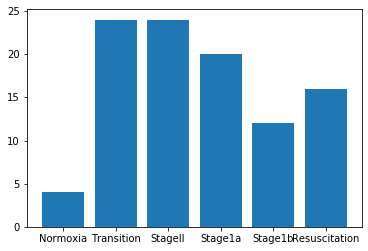

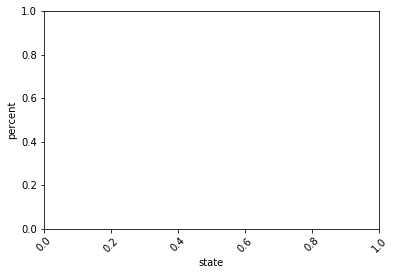

In [8]:
# State statistics
def plotStateDistributions():
    PERCENT = "percent"
    VALUE = "value"
    NAME = "name"
    trinary = TrinaryData(is_averaged=False, is_dropT1=False)
    df = pd.DataFrame(trinary.ser_y)
    df[VALUE] = list(np.repeat(1, len(df)))
    df_group = pd.DataFrame(df.groupby(NAME).count())
    dct = {v: k for k, v in trinary.state_dict.items()}
    df_group.index = [dct[s] for s in df_group.index]
    df_group[PERCENT] = 100*df_group[VALUE] / len(df)
    plotValuesByState(df_group.index, df_group[PERCENT])
    
plotStateDistributions()

In [9]:
# Classification accuracy by state
def stateClassificationAccuracy(state, num_iterations=10, is_averaged=False):
    NUM_HOLDOUTS = 1
    is_dropT1 = is_averaged
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_dropT1)
    df_X = trinary.df_X.copy()
    df_X.columns = trinary.features
    ser_y = trinary.ser_y
    results = []
    for _ in range(num_iterations):
        test_indices = []
        ser_sample = ser_y[ser_y == state].sample(n=NUM_HOLDOUTS)
        test_indices.extend(list(ser_sample.index))
        train_indices = list(set(df_X.index).difference(test_indices))
        svm_ensemble = classifier_ensemble.ClassifierEnsemble(
            classifier_ensemble.ClassifierDescriptorSVM(), size=30,
            filter_high_rank=1500,
            classes=list(ser_y.values))
        svm_ensemble.fit(df_X.loc[train_indices, :], ser_y.loc[train_indices])
        results.append(svm_ensemble.score(df_X.loc[test_indices, :], ser_y[test_indices]))
    return results

In [10]:
def plotStateAccuracies(is_averaged=True):
    is_dropT1 = is_averaged
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_dropT1)
    states = list(trinary.state_dict.values())
    avgs = []
    stds = []
    for state in states:
        values = stateClassificationAccuracy(state, is_averaged=is_averaged)
        avgs.append(np.mean(values))
        stds.append(np.std(values))
    plotValuesByState(list(trinary.state_dict.keys()), avgs, stds=stds, ylabel="accuracy")

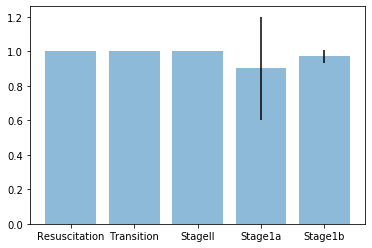

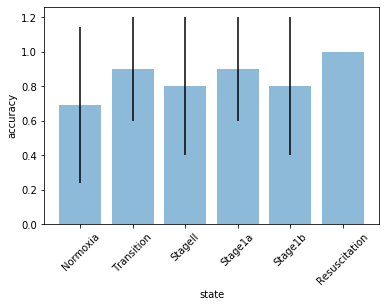

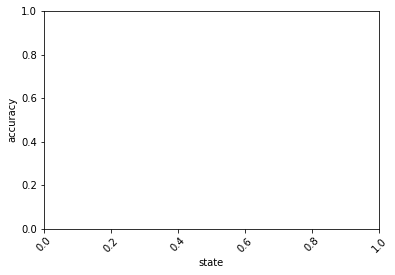

In [11]:
plotStateAccuracies(is_averaged=True)
plotStateAccuracies(is_averaged=False)

In [18]:
# Provide prediction probabilities for the state
def makeConfusionMatrix(is_averaged=False, filter_high_rank=15):
    """
    Constructs predictions for each observation for a classifier trained without that observation.
    :return pd.DataFrame:
      columns: state indices
      index: timepoint replication
      value: probability
    """
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_averaged)
    df_X = trinary.df_X.copy()
    df_X.columns = trinary.features
    ser_y = trinary.ser_y
    dfs = []
    for test_index in ser_y.index:
        train_indices = list(set(df_X.index).difference([test_index])) 
        svm_ensemble = classifier_ensemble.ClassifierEnsemble(
            classifier_ensemble.ClassifierDescriptorSVM(), size=50,
            filter_high_rank=filter_high_rank,
        )
        svm_ensemble.fit(df_X.loc[train_indices, :], ser_y.loc[train_indices])
        df_X_test = pd.DataFrame(df_X.loc[test_index, :]) 
        dfs.append(svm_ensemble.predict(df_X_test.T))
    return pd.concat(dfs)

In [16]:
df_confuse = makeConfusionMatrix()

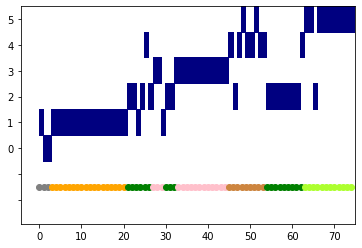

In [61]:
is_averaged = False
df = df_confuse.applymap(lambda v: np.nan if v <= 0.2 else 1)
df.columns = [c - 0.5 for c in df.columns]
trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_averaged)
states = trinary.ser_y.values
state_colors = ["grey", "orange", "green", "pink", "peru", "greenyellow"]
heatmap = plt.pcolor(df.T, cmap='jet')
#fig = heatmap.get_figure()
#axes = fig.get_axes()[0]
#yaxis = axes.get_yaxis()
#xv = [x + 0.5 for x in range(len(df.T.columns))]
#yv = [y + 0.5 for y in range(len(df.T))]
#plt.xticks(xv)
#plt.yticks(yv)
positions = [p - 0.5 for p in range(-1, len(states))]
labels = [str(int(c-.5)) if c >= 0 else "" for c in positions]
plt.yticks(positions, labels)
for idx, state in enumerate(states):
    color = state_colors[state]
    plt.scatter(idx, [-1], color=color)
#plt.colorbar(heatmap)


In [67]:
ser = df_confuse.loc["T1.0", :].idxmax()
ser

1

In [93]:
trinary = TrinaryData(is_averaged=False, is_dropT1=False)
for idx, value in enumerate(trinary.ser_y):
    print(idx, value)

0 0
1 0
2 0
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 2
22 2
23 2
24 2
25 2
26 2
27 3
28 3
29 3
30 2
31 2
32 2
33 3
34 3
35 3
36 3
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 4
46 4
47 4
48 4
49 4
50 4
51 4
52 4
53 4
54 2
55 2
56 2
57 2
58 2
59 2
60 2
61 2
62 2
63 5
64 5
65 5
66 5
67 5
68 5
69 5
70 5
71 5
72 5
73 5
74 5


In [69]:
values = []
for idx in df_confuse.index:
    values.append(df_confuse.loc[idx, :].idxmax())
values
    

[1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 4,
 2,
 3,
 3,
 1,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 2,
 4,
 5,
 4,
 4,
 5,
 4,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 5,
 5,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5]

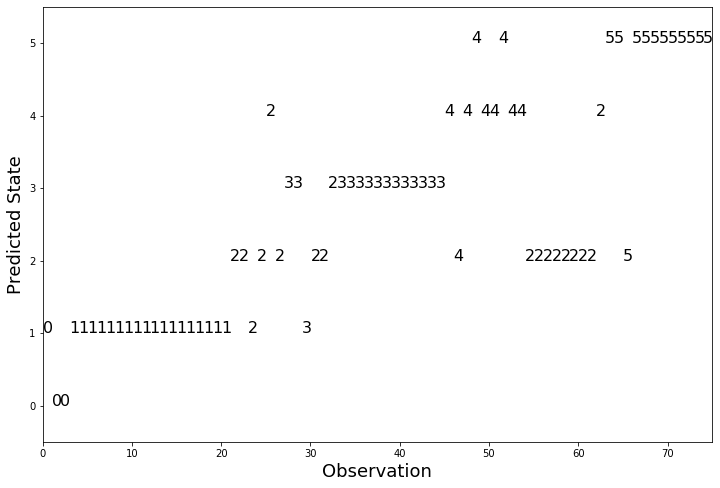

In [91]:
# Text plotplot predicted vs. actual for values in each state
is_averaged = False
predicted_states = []
for idx in df_confuse.index:
    predicted_states.append(df_confuse.loc[idx, :].idxmax())
trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=is_averaged)
states = trinary.ser_y.values
plt.figure(figsize=(12, 8))
plt.scatter([-1,80], [-1,7])
for obs in range(len(values)):
    _ = plt.text(obs, values[obs], "%d" % states[obs], fontsize=16)
plt.xlim([0, 75])
plt.ylim([-0.5, 5.5])
_ = plt.xlabel("Observation", fontsize=18)
_ = plt.ylabel("Predicted State", fontsize=18)

## Expression Variability Within State